In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

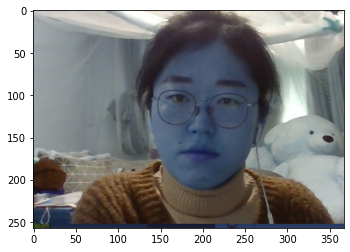

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

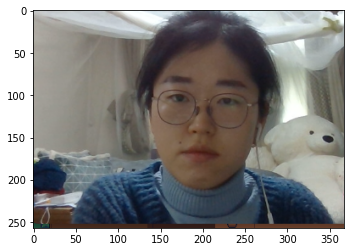

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
face_img_size = img_rgb.shape
face_img_size

(257, 367, 3)

detector 선언

In [5]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

In [6]:
# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(139, 67) (268, 196)]]


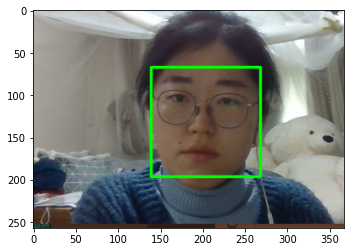

In [7]:

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [8]:
# 저장한 landmark 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor는 RGB이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection을 반환

In [9]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


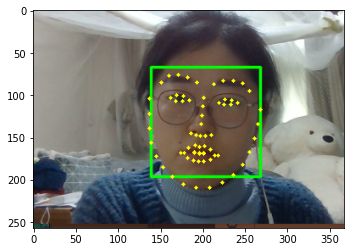

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 index는 30 입니다
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h))

(197, 148)
(x,y) : (197,83)
(w,h) : (130,130)


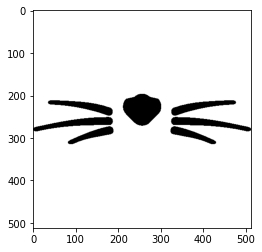

In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show()

(130, 130, 3)


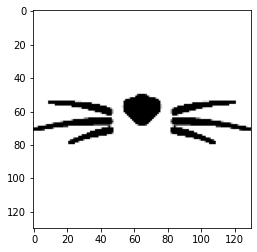

In [13]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [14]:
refined_x = x -(w//2)
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (132,83)


In [15]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (132,83)


In [16]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


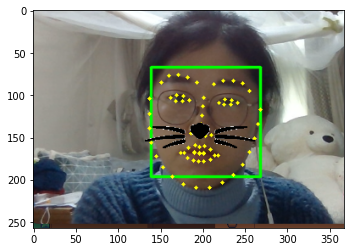

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

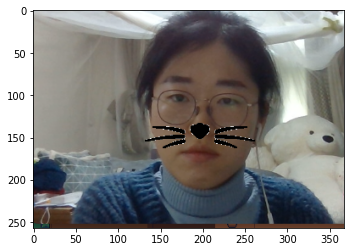

In [18]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 생각하기

1. 얼굴 각도에 따라 스티커가 어떻게 변해야 할까요?
  - dlib의 get_frontal_face_detector은 정면 얼굴에 대한 특징부분의 랜드마킹하여 점을 추출하는 기능을한다.
    얼굴의 각도가 정면이 아닌 좌,우로 변하게 되어도 get_frontal_face_detector 은 정면으로 인식하여 특징점이 다른 곳에 랜드마킹되어 생각하지 못한 곳에 스티커가 붙게 된다.

2. 멀리서 촬영하면 왜 안될까? 옆으로 누워서 촬영하면 왜 안될까?
- 멀리서 촬영할 경우 얼굴이 매우 작게 표시된다. 이러한 사진은 현재 실행한 스티커앱에 적용하게 되면 resize통해 더욱 작은 곳에만 얼굴이 표시된다. 이렇게 매우 작게 표시된 얼굴은 인식을 할 수 없어 오류가 발생된다.

- 옆으로 누워서 촬영할 경우 불필요한 요소도 같이 촬영되기 때문에 얼굴만 인식이 안되게 된다.

3. 실행 속도가 중요할까?
- 현재 출시되어 있는 App 대부분이 실행속도에 따라 사용자의 수가 결정되기도 한다
- 실행 속도가 느리게 되면 사용자는 해당 기능이 안되는 것으로 생각되기 떄문에
  실행 속도 또한 중요하다고 생각된다.

4. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
- 스티커앱을 만들 때 정확도가 어느 정도는 있어야 한다고 생각한다.
- 자신이 원하는 위치에 해당 스티커가 붙여지지 않으면 해당 App을 사용하는 의미가 없다고 사용자가 생각하여 결국 스티커앱을 사용하지 않을 것이기 때문이다.